# Test CLUE performance

In this notebook, we test CLUE's performance for 3 different setups of a Bayesian last-layer MNIST classifier. 

We allow a choice between:
- Classifier dominated backbone 
- Joint training backbone
- Autoencoder dominated backbone

## Setup


In [78]:
inDrive = False

In [79]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/MyImplementation/testing_notebooks')
    import sys

    # Add the parent directory to the system path
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0, parent_dir)

Import libraries

In [80]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler
import models.regene_models


Set the configuration

In [81]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512
    latent_dim = 256

    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'

cfg = Config()

In [82]:
models_dir = '../model_saves/new_regene_models'
results_dir = '../results/new_regene_models'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Backbone
We'll start with the backbone loading. Options are either classifier_dominated, joint_training, or autoencoder_dominated.

In [83]:
classifier_dominated = False
joint_training = True
autoencoder_dominated = False

### Load chosen model

Load model

In [84]:
importlib.reload(models.regene_models)

decoder = models.regene_models.Decoder(latent_dim=cfg.latent_dim, device=cfg.device)
backbone = models.regene_models.Classifier(latent_dim=cfg.latent_dim, num_classes=10, device=cfg.device)

if classifier_dominated:
    backbone.load(models_dir + '/classifier_dominated_classifier_256.pt')
    decoder.load(models_dir + '/classifier_dominated_decoder_256.pt')
    name = 'classifier_dominated'
    bll_name = 'BLL_VI_classifier_dominated_first_256.pt'
elif joint_training:
    backbone.load(os.path.join(models_dir, 'joint_classifier_256.pt'))
    decoder.load(os.path.join(models_dir, 'joint_decoder_256.pt'))
    name = 'joint_training'
    bll_name = 'BLL_VI_joint_training_first_256.pt'
elif autoencoder_dominated:
    backbone.load(models_dir + '/autoencoder_dominated_classifier_full_256.pt')
    decoder.load(models_dir + '/autoencoder_dominated_decoder_256.pt')
    name = 'autoencoder_dominated'
    bll_name = 'BLL_VI_autoencoder_dominated_first_256.pt'

Loaded classifier model from: ../model_saves/new_regene_models/joint_classifier_256.pt
Loaded decoder model from: ../model_saves/new_regene_models/joint_decoder_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/regene_models.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lo

Load the Datasets

In [85]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

## Bayesian Last Layer - VI
Next we'll train a variational inference version of the Bayesian last layer using the chosen backbone.


In [86]:
if inDrive: 
    %pip install torchbnn

### Load the model

In [87]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=cfg.latent_dim,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    device=cfg.device
)

# Verify all model components are on the correct device
print(f"Backbone device: {next(bll_vi.backbone.parameters()).device}")
print(f"Last layer device: {next(bll_vi.last_layer.parameters()).device}")

bll_vi.load_checkpoint(os.path.join(models_dir, bll_name))

Backbone device: mps:0
Last layer device: mps:0
 [load_checkpoint] Loaded checkpoint from ../model_saves/new_regene_models/BLL_VI_joint_training_first_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL_VI.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

### Test the model
To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.


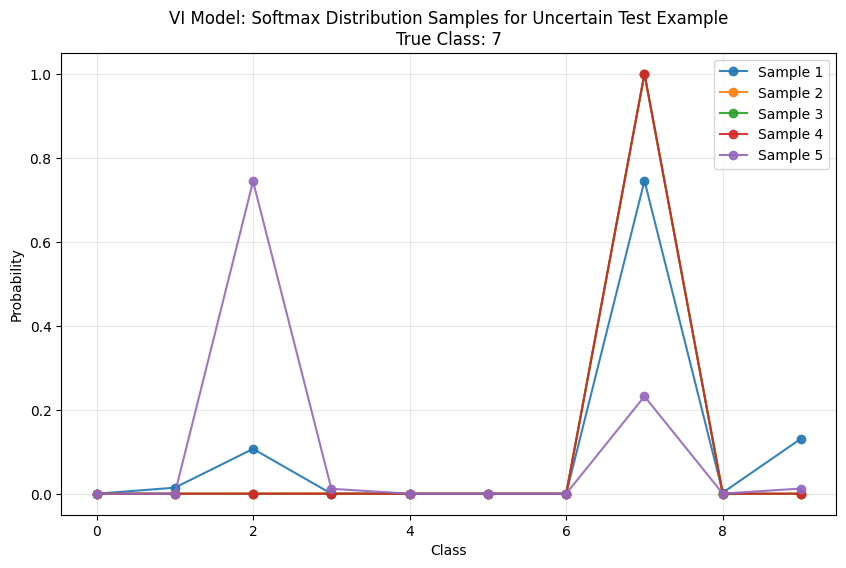

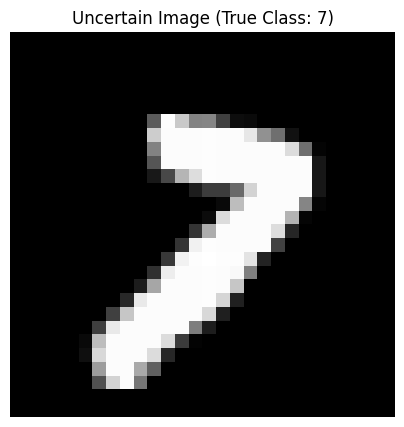

In [88]:
import torch.nn.functional as F

# Search for an uncertain prediction and visualize multiple samples
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]

            # Get multiple predictions for this single example
            outputs = []
            with torch.no_grad():  # Add no_grad context
                for _ in range(num_samples):
                    logits = bll_vi(x_single)
                    probs = F.softmax(logits, dim=1)
                    outputs.append(probs)

            # Stack predictions
            probs = torch.stack(outputs)  # Shape: [num_samples, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [num_samples, num_classes]

            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.9:  # If average confidence is less than 60%
                found_uncertain = True
                break

except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].detach().cpu().numpy(), 'o-', alpha=0.9, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'VI Model: Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()

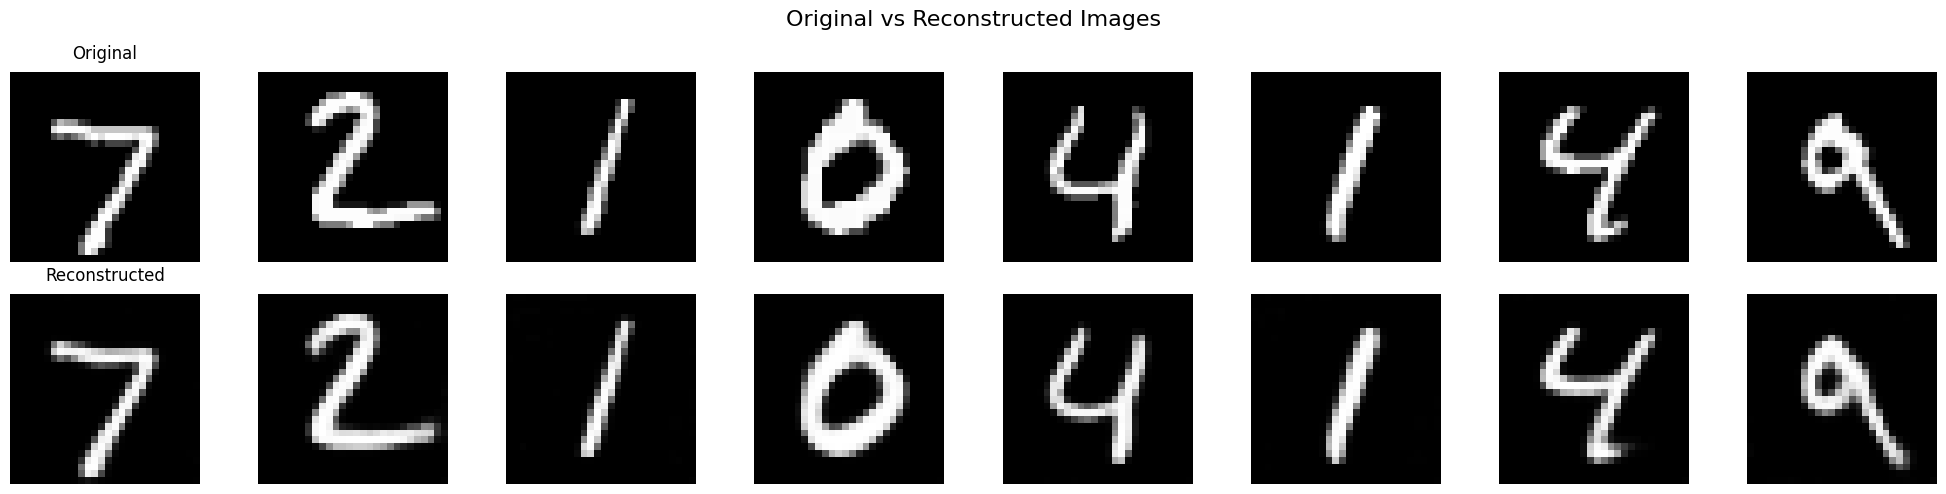

Reconstruction MSE: 0.0035


In [89]:
# Get test images
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(cfg.device)

# Get reconstructions using the classifier and decoder
with torch.no_grad():
    # Get latent representations from classifier
    latent_reps, _ = backbone(test_images)  # Returns (latent_rep, logits)
    # Reconstruct using decoder
    reconstructions = decoder(latent_reps)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions
for i in range(8):
    axes[1,i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()

# Optionally, calculate reconstruction error
mse = nn.MSELoss()
recon_error = mse(reconstructions, test_images)
print(f'Reconstruction MSE: {recon_error.item():.4f}')

In [19]:
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import visualize_latent_space_tsne, project_new_points_on_tsne

Extracting embeddings:   3%|▎         | 3/94 [00:02<01:20,  1.13it/s]


Running t-SNE on 2000 samples with 256 dimensions...


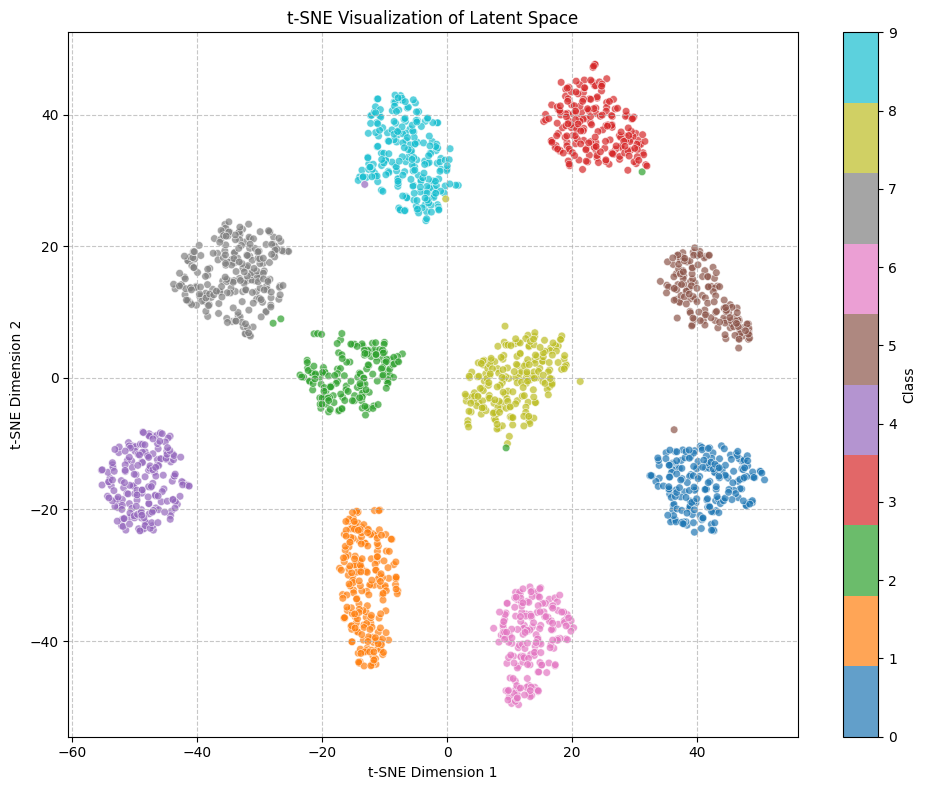

In [23]:
bll_tsne, bll_embeddings, bll_labels, bll_fig, bll_ax = visualize_latent_space_tsne(model=bll_vi, dataloader=trainloader, device=cfg.device, show_plot=True, return_data=True, n_samples=2000)

## Evaluate CLUE

### Load the VAE

In [25]:
from models.VAE_likelihood import ConvVAELikelihoodEstimator

vae = ConvVAELikelihoodEstimator(latent_dim=20, device=cfg.device)

vae.load_state_dict(torch.load(os.path.join(models_dir, 'vae_likelihood_estimator_20.pt'), map_location=cfg.device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_29607/344240935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(mo

<All keys matched successfully>

### Get Uncertain Images

In [90]:
import importlib
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_clue_counterfactuals, find_uncertain_images, visualize_counterfactual_results, evaluate_single_clue_counterfactual

In [91]:
uncertain_images, uncertain_indices = find_uncertain_images(bll_vi, testloader, n=50, device=cfg.device)

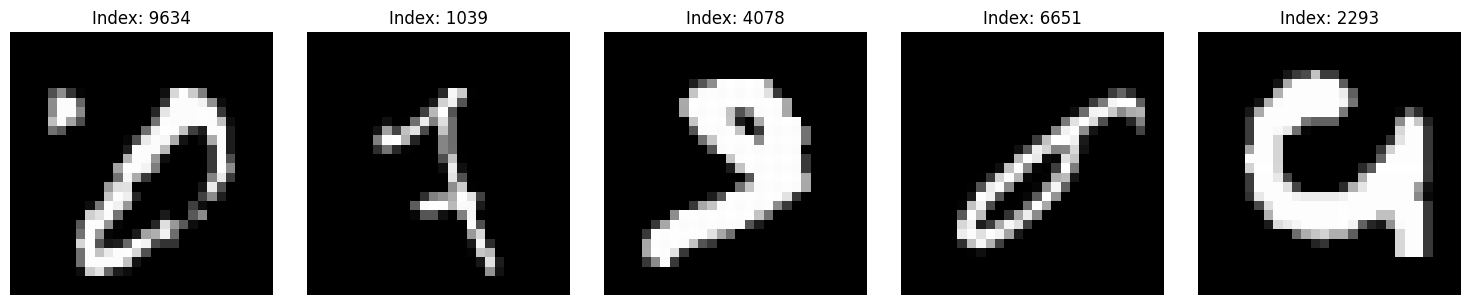

Uncertainty indices of these images: [9634, 1039, 4078, 6651, 2293]


In [17]:
# Plot the first 5 uncertain images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(uncertain_images[i, 0].cpu(), cmap='gray')
    plt.title(f"Index: {uncertain_indices[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Uncertainty indices of these images:", uncertain_indices[:5].tolist())

### Test a single image

Step 00: Loss: 8.3521, Target Class Prob: 0.0002, Distance: 0.0000
Step 01: Loss: 6.8065, Target Class Prob: 0.0011, Distance: 1.6000
Step 02: Loss: 5.3126, Target Class Prob: 0.0049, Distance: 3.1384
Step 03: Loss: 3.8673, Target Class Prob: 0.0209, Distance: 4.6555
Step 04: Loss: 2.4988, Target Class Prob: 0.0822, Distance: 6.1548
Step 05: Loss: 1.3176, Target Class Prob: 0.2680, Distance: 7.6347
Step 06: Loss: 0.5281, Target Class Prob: 0.5903, Distance: 9.0821
Step 07: Loss: 0.1755, Target Class Prob: 0.8399, Distance: 10.4570
Step 08: Loss: 0.0583, Target Class Prob: 0.9444, Distance: 11.7199
Step 09: Loss: 0.0216, Target Class Prob: 0.9799, Distance: 12.8615
Step 10: Loss: 0.0094, Target Class Prob: 0.9920, Distance: 13.8891
Step 11: Loss: 0.0049, Target Class Prob: 0.9966, Distance: 14.8142
Step 12: Loss: 0.0032, Target Class Prob: 0.9984, Distance: 15.6482
Step 13: Loss: 0.0025, Target Class Prob: 0.9992, Distance: 16.4014
Step 14: Loss: 0.0022, Target Class Prob: 0.9995, Dista

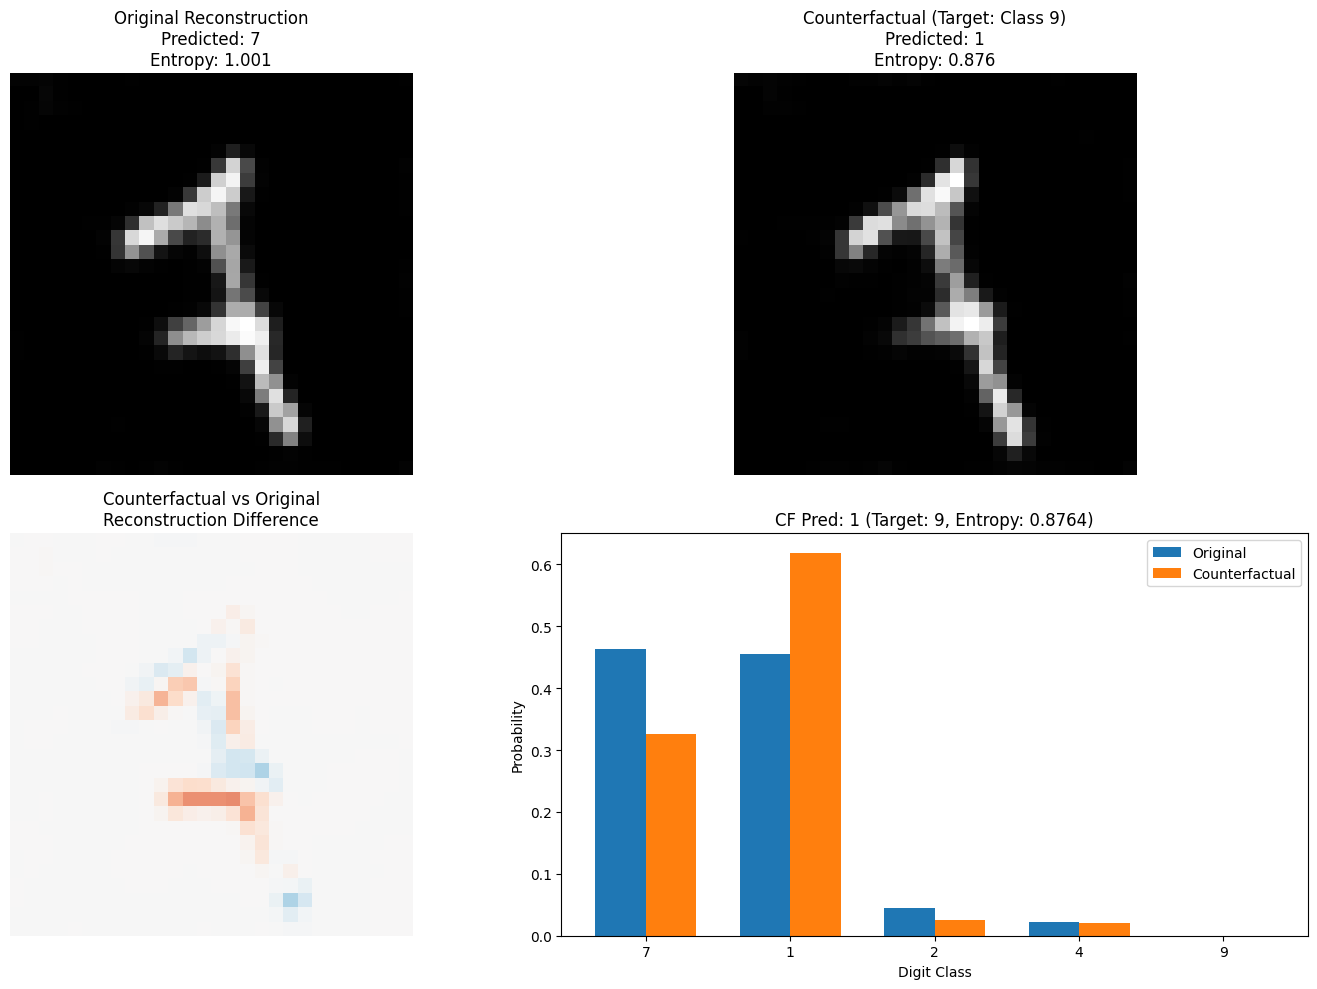


CLUE Counterfactual Results:
Latent Distance: 23.645
Latent Entropy Reduction: 1.050
Reconstruction Entropy Reduction: 0.124

Class probabilities:
Original (Predicted: 7): [0.    0.455 0.044 0.016 0.022 0.    0.    0.464 0.    0.   ]
Counterfactual (Predicted: 1, Target: 9): [0.    0.619 0.026 0.008 0.021 0.    0.    0.326 0.    0.   ]

Likelihood metrics:
Original log-likelihood: -89.37
Reconstruction log-likelihood: -104.31
Counterfactual log-likelihood: -104.10
Log-likelihood difference (original vs CF): 14.73
Log-likelihood difference (recon vs CF): -0.21
Likelihood ratio (CF/original): 0.00x
Likelihood ratio (CF/recon): 1.23x
Original realism score: 0.986
Reconstruction realism score: 0.980
Counterfactual realism score: 0.981
Realism score difference (original vs CF): 0.005
Realism score difference (recon vs CF): -0.001


In [45]:
import clue.new_CLUE
importlib.reload(clue.new_CLUE)

bayesian = False

if bayesian:
    model = bll_vi
else:
    model = backbone

results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[1],
    model,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=200,
    distance_weight=0.0001,
    lr=0.1,
    target_class=9,
    bayesian=bayesian,
    ReconstructionOnly=True
)

### Get average metrics

In [ ]:
results = evaluate_clue_counterfactuals(
    uncertain_images[10:20],
    bll_vi,
    decoder,
    vae,
    device=cfg.device,
    steps=200,
    lr=0.05,
    distance_weight=0.005,
)

KeyboardInterrupt: 


Aggregate Results over 10 images:
Average latent entropy reduction: 1.360
Average reconstruction entropy reduction: 0.739
Average latent distance: 25.202
Average log likelihood difference: 9.543
Average realism score difference: 0.003


Example 1 (Image Index: 7):
Latent entropy reduction: 1.583
Latent distance: 31.666
Log likelihood difference: -14.819
Original class prediction: 9
Counterfactual class prediction: 9

Example 2 (Image Index: 2):
Latent entropy reduction: 1.475
Latent distance: 30.338
Log likelihood difference: 4.699
Original class prediction: 1
Counterfactual class prediction: 1

Example 3 (Image Index: 8):
Latent entropy reduction: 1.414
Latent distance: 25.127
Log likelihood difference: 20.361
Original class prediction: 9
Counterfactual class prediction: 9

Example 4 (Image Index: 1):
Latent entropy reduction: 1.394
Latent distance: 20.476
Log likelihood difference: 26.466
Original class prediction: 5
Counterfactual class prediction: 5

Example 5 (Image Index: 9):
La

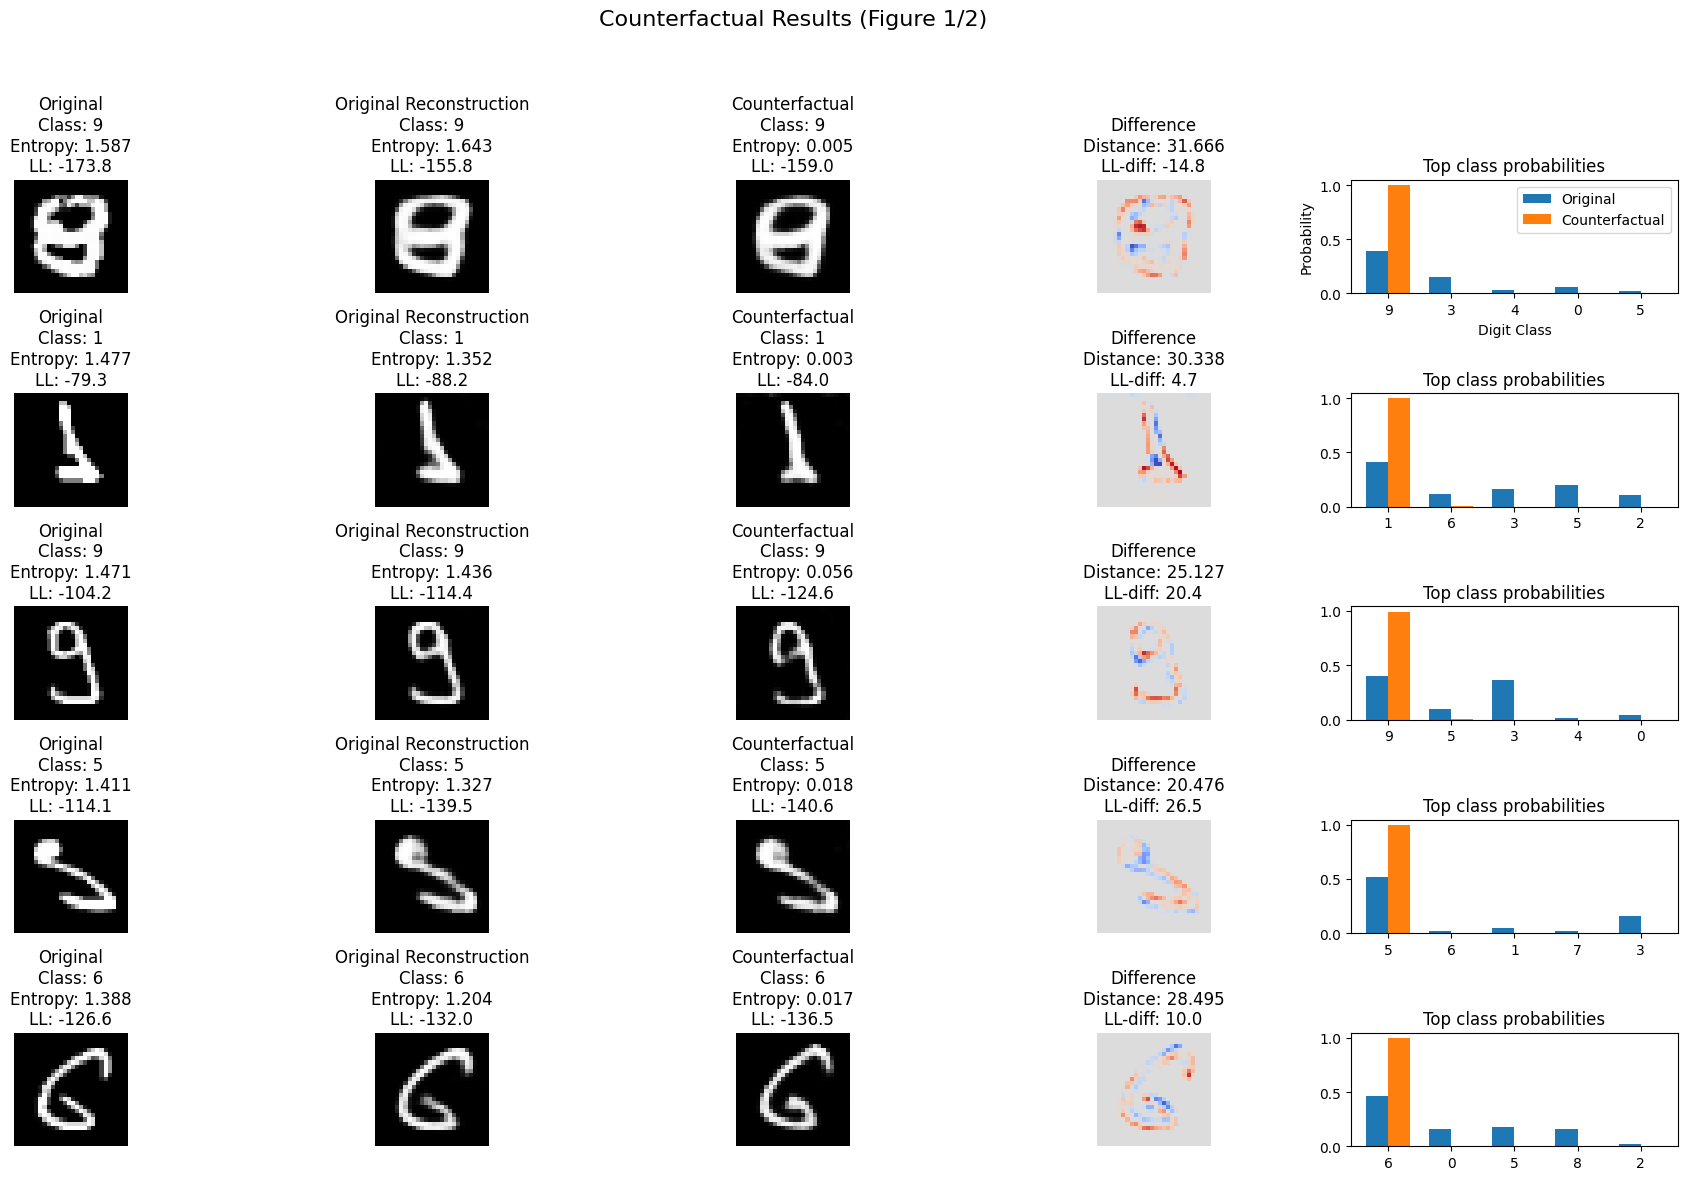

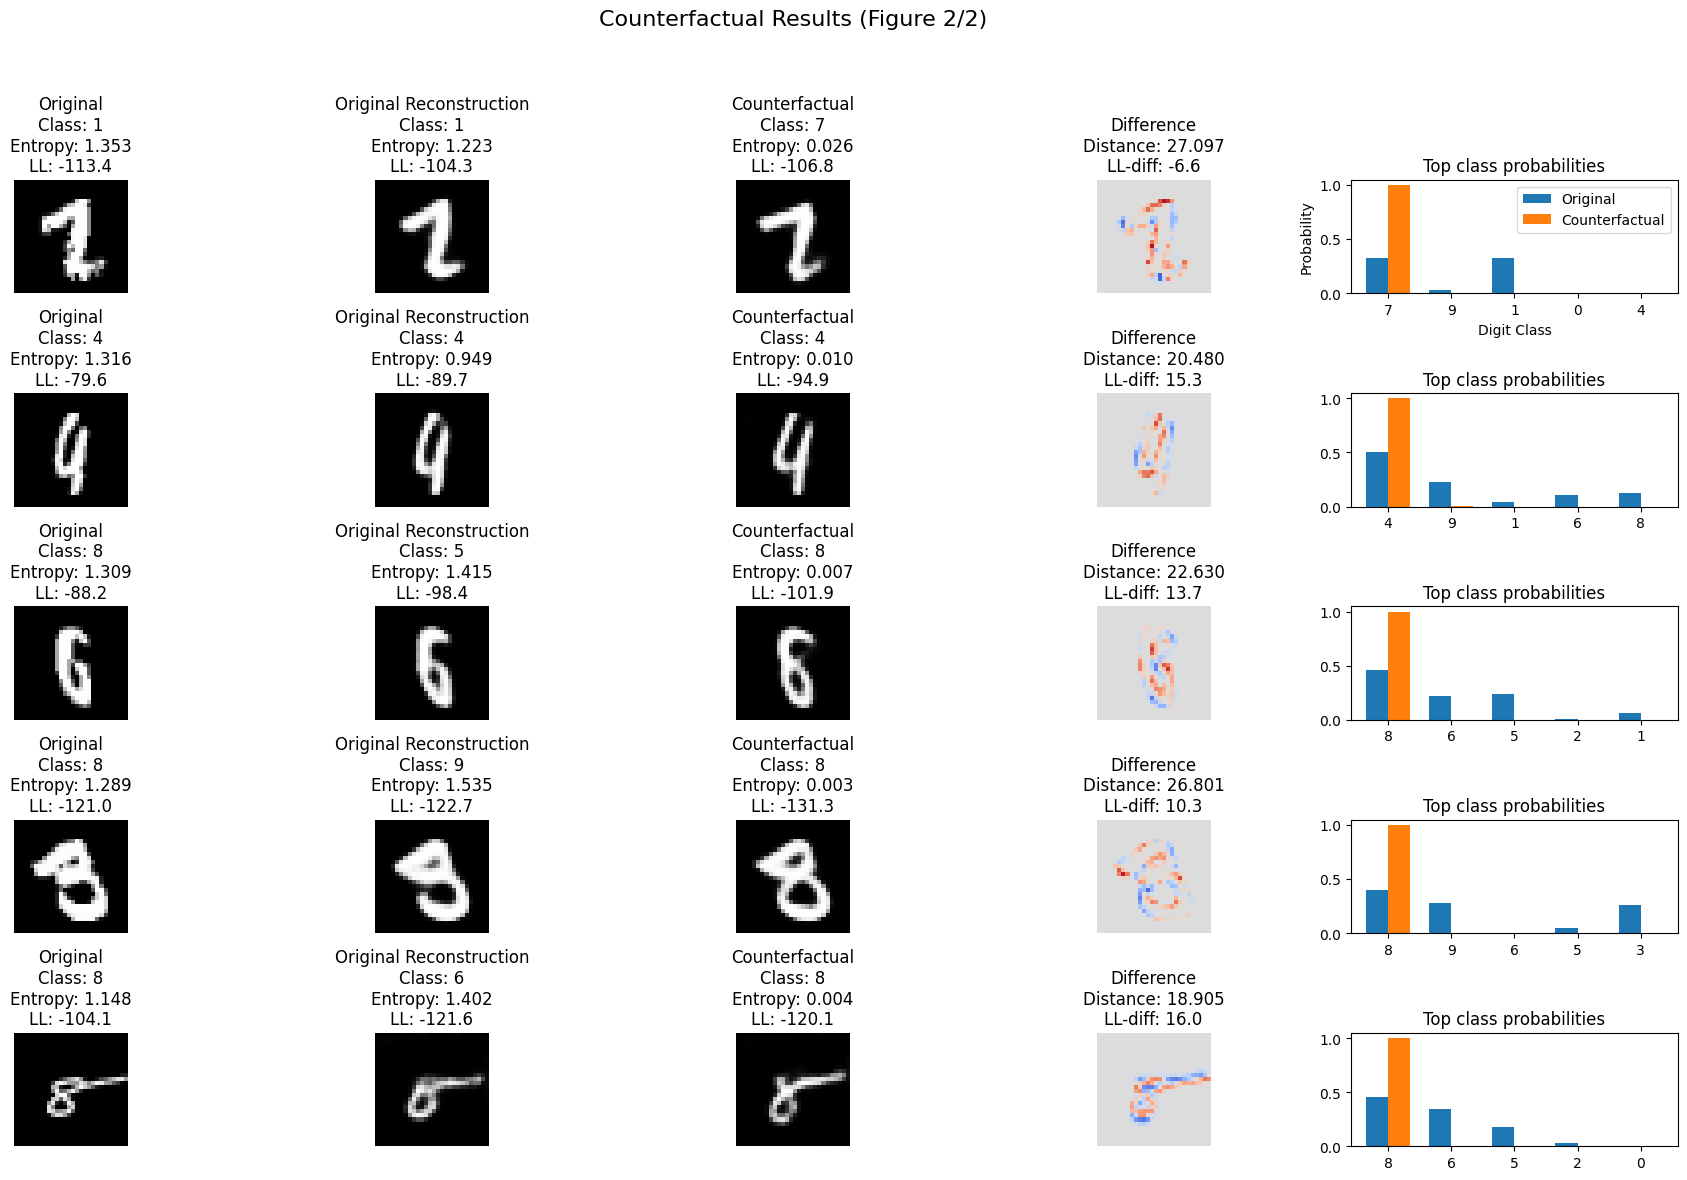

In [ ]:
visualize_counterfactual_results(results, n=10)

In [ ]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import save_counterfactual_results_to_csv

results_directory= models_dir + '/CLUE_results'

save_counterfactual_results_to_csv(results, output_dir=results_directory, suffix='joint_model_256_few_samples')

Individual results saved to: ../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/individual_results.csv
Aggregate results saved to: ../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/aggregate_results.csv


('../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/individual_results.csv',
 '../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/aggregate_results.csv')

## Evaluate CLUE (Deterministic)

### Load the VAE

In [79]:
from models.VAE_likelihood import ConvVAELikelihoodEstimator

vae = ConvVAELikelihoodEstimator(latent_dim=20, device=cfg.device)

vae.load_state_dict(torch.load(os.path.join(models_dir, 'vae_likelihood_estimator_20.pt'), map_location=cfg.device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_3837/344240935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(mod

<All keys matched successfully>

### Get Uncertain Images

In [80]:
import importlib
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_clue_counterfactuals, find_uncertain_images, visualize_counterfactual_results, evaluate_single_clue_counterfactual

In [115]:
uncertain_images, uncertain_indices = find_uncertain_images(backbone, testloader, n=50, device=cfg.device, bayesian=False)

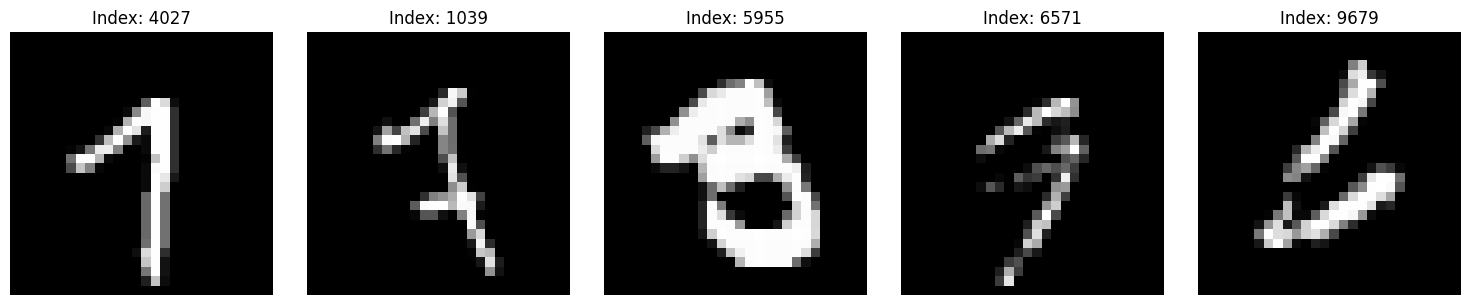

Uncertainty indices of these images: [4027, 1039, 5955, 6571, 9679]


In [135]:
# Plot the first 5 uncertain images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(uncertain_images[i, 0].cpu(), cmap='gray')
    plt.title(f"Index: {uncertain_indices[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Uncertainty indices of these images:", uncertain_indices[:5].tolist())

### Test a single image

Step 00: Loss: 0.4461, Total Entropy: 0.4461, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.4461, Distance: 0.0000
Step 01: Loss: 0.2758, Total Entropy: 0.2718, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.2718, Distance: 0.8000
Step 02: Loss: 0.1695, Total Entropy: 0.1617, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.1617, Distance: 1.5629
Step 03: Loss: 0.1083, Total Entropy: 0.0969, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0969, Distance: 2.2772
Step 04: Loss: 0.0743, Total Entropy: 0.0597, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0597, Distance: 2.9321
Step 05: Loss: 0.0557, Total Entropy: 0.0380, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0380, Distance: 3.5239
Step 06: Loss: 0.0455, Total Entropy: 0.0252, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0252, Distance: 4.0540
Step 07: Loss: 0.0400, Total Entropy: 0.0173, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0173, Distance: 4.5261
Step 08: Loss: 0.0371, Total Entropy: 0.0124, Epistemic Entropy:

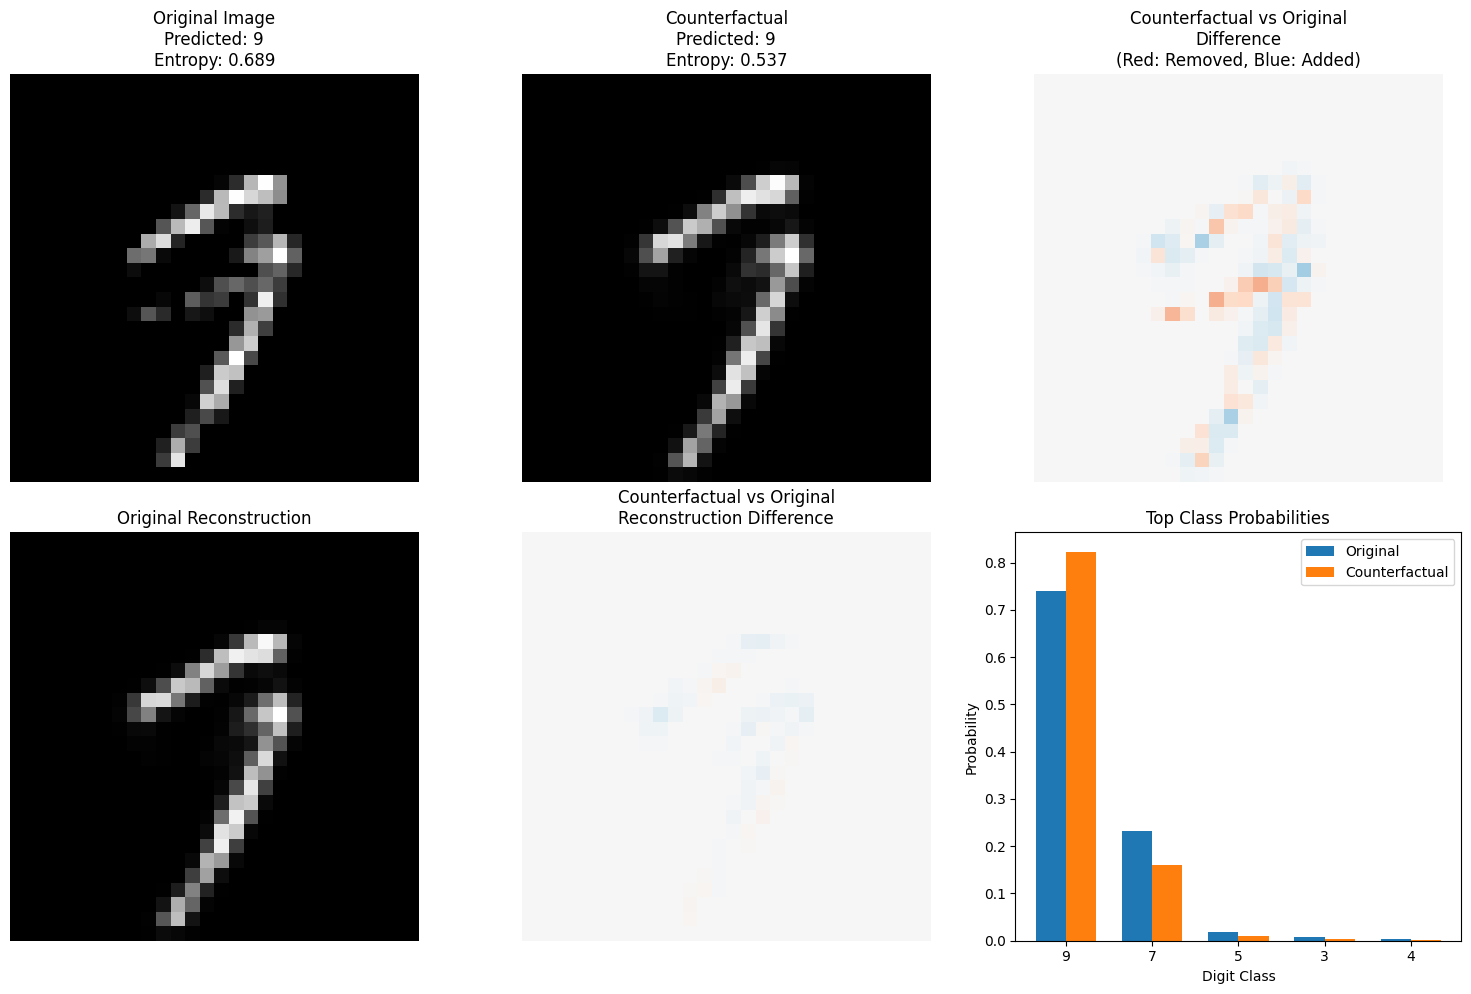


CLUE Counterfactual Results:
Latent Distance: 4.590
Latent Entropy Reduction: 0.441
Reconstruction Entropy Reduction: 0.152

Class probabilities:
Original (Predicted: 9): [0.    0.    0.    0.008 0.003 0.018 0.    0.231 0.    0.74 ]
Counterfactual (Predicted: 9): [0.    0.    0.    0.004 0.002 0.01  0.    0.161 0.    0.823]

Likelihood metrics:
Original log-likelihood: -85.17
Counterfactual log-likelihood: -84.48
Log-likelihood difference: -0.69
Likelihood ratio: 2.00x more likely
Original realism score: 0.987
Counterfactual realism score: 0.987
Realism score difference: -0.000


In [136]:
results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[3],
    backbone,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=200,
    distance_weight=0.005,
    lr=0.05,
    bayesian=False
)

### Get average metrics

In [137]:
results = evaluate_clue_counterfactuals(
    uncertain_images,
    backbone,
    decoder,
    vae,
    device=cfg.device,
    steps=200,
    lr=0.05,
    distance_weight=0.005,
    bayesian=False
)


Aggregate Results over 50 images:
Average latent entropy reduction: 0.691
Average reconstruction entropy reduction: 0.225
Average latent distance: 4.789
Average log likelihood difference: 3.419
Average realism score difference: 0.001


Example 1 (Image Index: 10):
Latent entropy reduction: 1.406
Latent distance: 6.549
Log likelihood difference: 1.142
Original class prediction: 9
Counterfactual class prediction: 9

Example 2 (Image Index: 21):
Latent entropy reduction: 1.363
Latent distance: 5.727
Log likelihood difference: 4.273
Original class prediction: 4
Counterfactual class prediction: 4

Example 3 (Image Index: 44):
Latent entropy reduction: 1.309
Latent distance: 5.510
Log likelihood difference: 2.906
Original class prediction: 1
Counterfactual class prediction: 1

Example 4 (Image Index: 1):
Latent entropy reduction: 1.272
Latent distance: 6.221
Log likelihood difference: 3.992
Original class prediction: 9
Counterfactual class prediction: 9

Example 5 (Image Index: 16):
Latent 

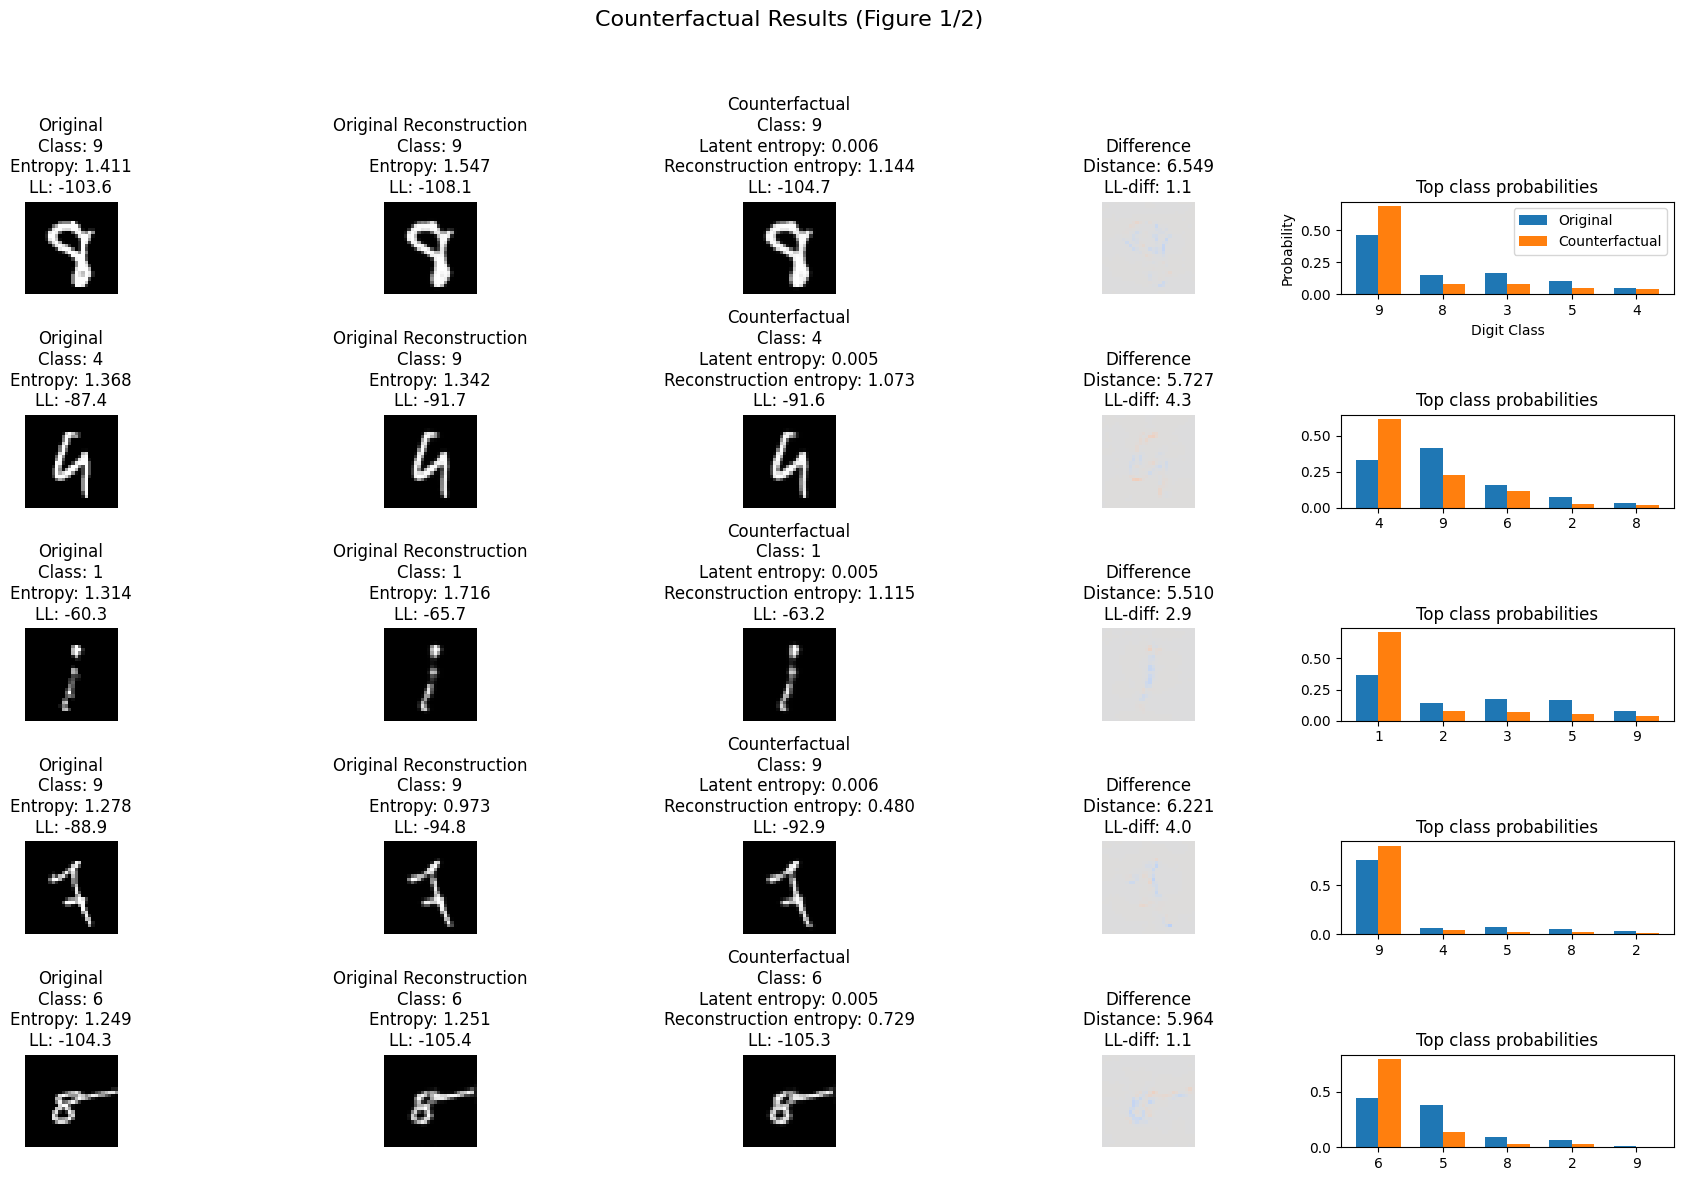

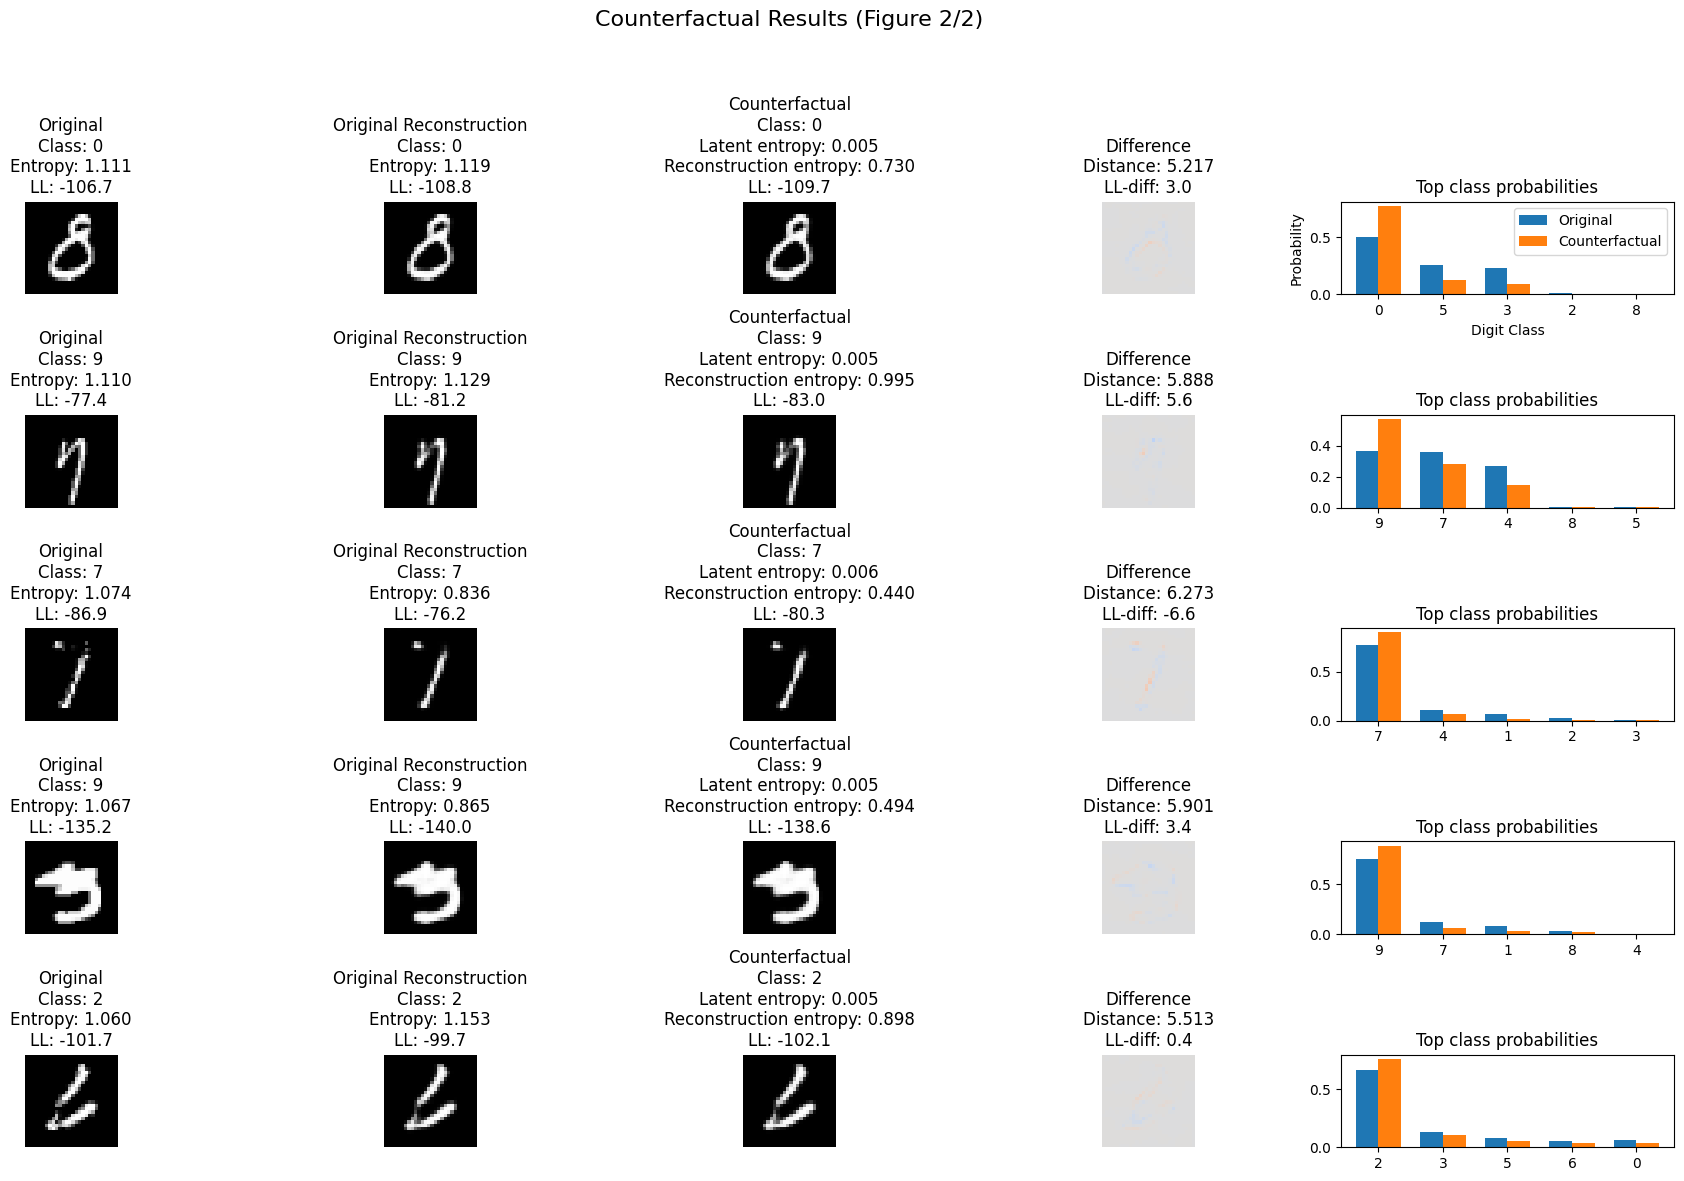

In [138]:
visualize_counterfactual_results(results, n=10)

In [139]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import save_counterfactual_results_to_csv

results_directory= models_dir + '/CLUE_results'

save_counterfactual_results_to_csv(results, output_dir=results_directory, suffix='DETERMINISTIC_autoencoder_dominated_model_256_50_samples')

Individual results saved to: ../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/individual_results.csv
Aggregate results saved to: ../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/aggregate_results.csv


('../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/individual_results.csv',
 '../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/aggregate_results.csv')

## Test Counterfactual - Specify Class

Test a single image

Step 00: Loss: 12.3260, Target Class Prob: 0.0000, Distance: 0.0000
Step 01: Loss: 10.9761, Target Class Prob: 0.0000, Distance: 1.6000
Step 02: Loss: 9.6314, Target Class Prob: 0.0001, Distance: 3.1629
Step 03: Loss: 8.2910, Target Class Prob: 0.0003, Distance: 4.7276
Step 04: Loss: 6.9549, Target Class Prob: 0.0010, Distance: 6.2889
Step 05: Loss: 5.6244, Target Class Prob: 0.0039, Distance: 7.8441
Step 06: Loss: 4.3049, Target Class Prob: 0.0148, Distance: 9.3926
Step 07: Loss: 3.0185, Target Class Prob: 0.0545, Distance: 10.9347
Step 08: Loss: 1.8385, Target Class Prob: 0.1802, Distance: 12.4687
Step 09: Loss: 0.9335, Target Class Prob: 0.4522, Distance: 13.9847
Step 10: Loss: 0.4448, Target Class Prob: 0.7480, Distance: 15.4504
Step 11: Loss: 0.2652, Target Class Prob: 0.9075, Distance: 16.8188
Step 12: Loss: 0.2143, Target Class Prob: 0.9669, Distance: 18.0660
Step 13: Loss: 0.2046, Target Class Prob: 0.9874, Distance: 19.1919
Step 14: Loss: 0.2072, Target Class Prob: 0.9948, Dis

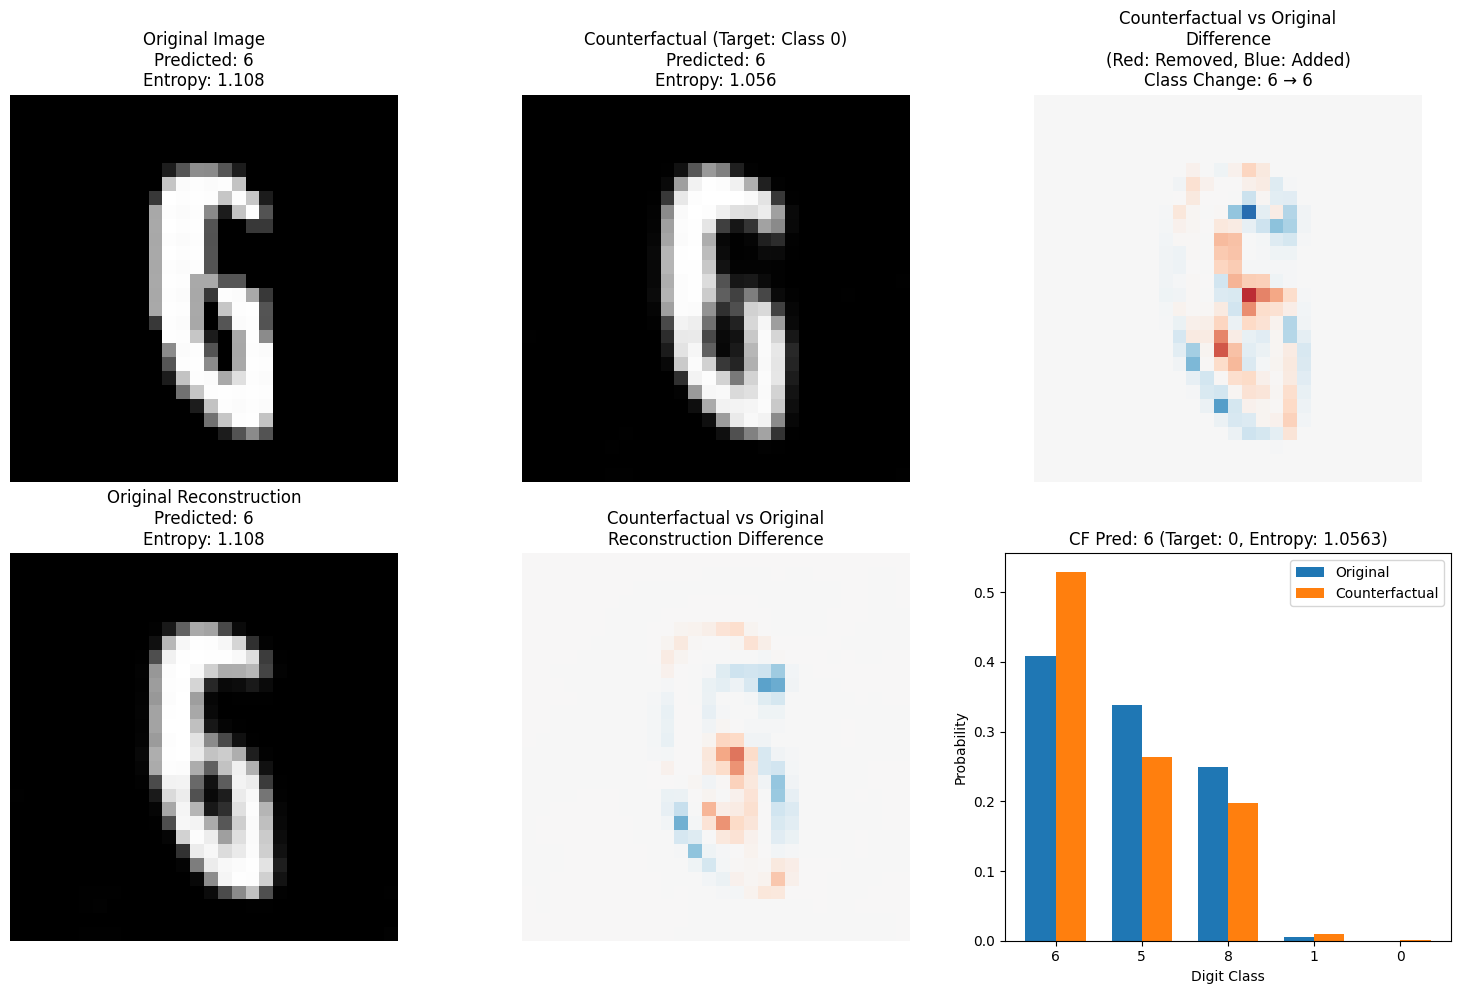


CLUE Counterfactual Results:
Latent Distance: 19.983
Latent Entropy Reduction: 0.853
Reconstruction Entropy Reduction: 0.051

Class probabilities:
Original (Predicted: 6): [0.    0.006 0.    0.    0.    0.338 0.408 0.    0.249 0.   ]
Counterfactual (Predicted: 6, Target: 0): [0.001 0.009 0.    0.    0.    0.263 0.53  0.    0.198 0.   ]

Likelihood metrics:
Original log-likelihood: -88.40
Reconstruction log-likelihood: -95.63
Counterfactual log-likelihood: -105.63
Log-likelihood difference (original vs CF): 17.23
Log-likelihood difference (recon vs CF): 10.00
Likelihood ratio (CF/original): 0.00x
Likelihood ratio (CF/recon): 0.00x
Original realism score: 0.985
Reconstruction realism score: 0.983
Counterfactual realism score: 0.980
Realism score difference (original vs CF): 0.005
Realism score difference (recon vs CF): 0.003


In [130]:
bayesian = False

if bayesian:
    model = bll_vi
else:
    model = backbone


results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[10],
    model,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=150,
    distance_weight=0.01,
    lr=0.1,
    bayesian=bayesian,
    target_class=0
)

Visualise the latent space trajectory

Extracting embeddings:  20%|██        | 4/20 [00:02<00:09,  1.66it/s]


Running t-SNE on 2051 samples with 256 dimensions...


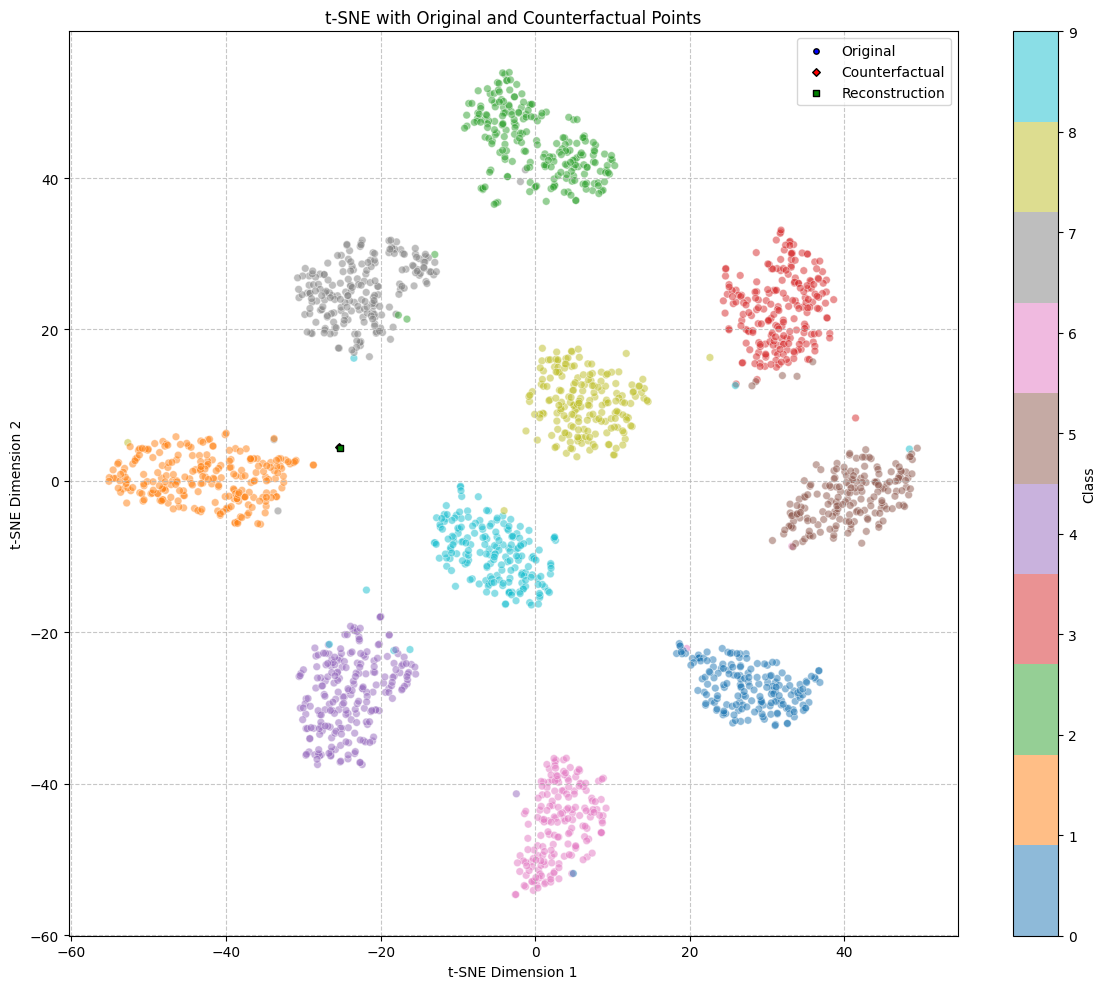

In [115]:
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import visualize_latent_space_with_special_points

# Use the function with your data
tsne, fig, ax, coords = visualize_latent_space_with_special_points(
    dataloader=testloader,
    model=bll_vi,
    original_latent=results['original_latent'],
    counterfactual_latent=results['counterfactual_latent'],
    reconstruction_latent=bll_vi.extract_features(results['counterfactual_image']),  # Optional, include if you have it
    batch_size=2000,  # Use a subset of the data for faster computation
    device=cfg.device,
    title="t-SNE with Original and Counterfactual Points"
)

Extracting embeddings:  30%|███       | 6/20 [00:02<00:06,  2.32it/s]


Running PCA on 3075 samples with 256 dimensions...


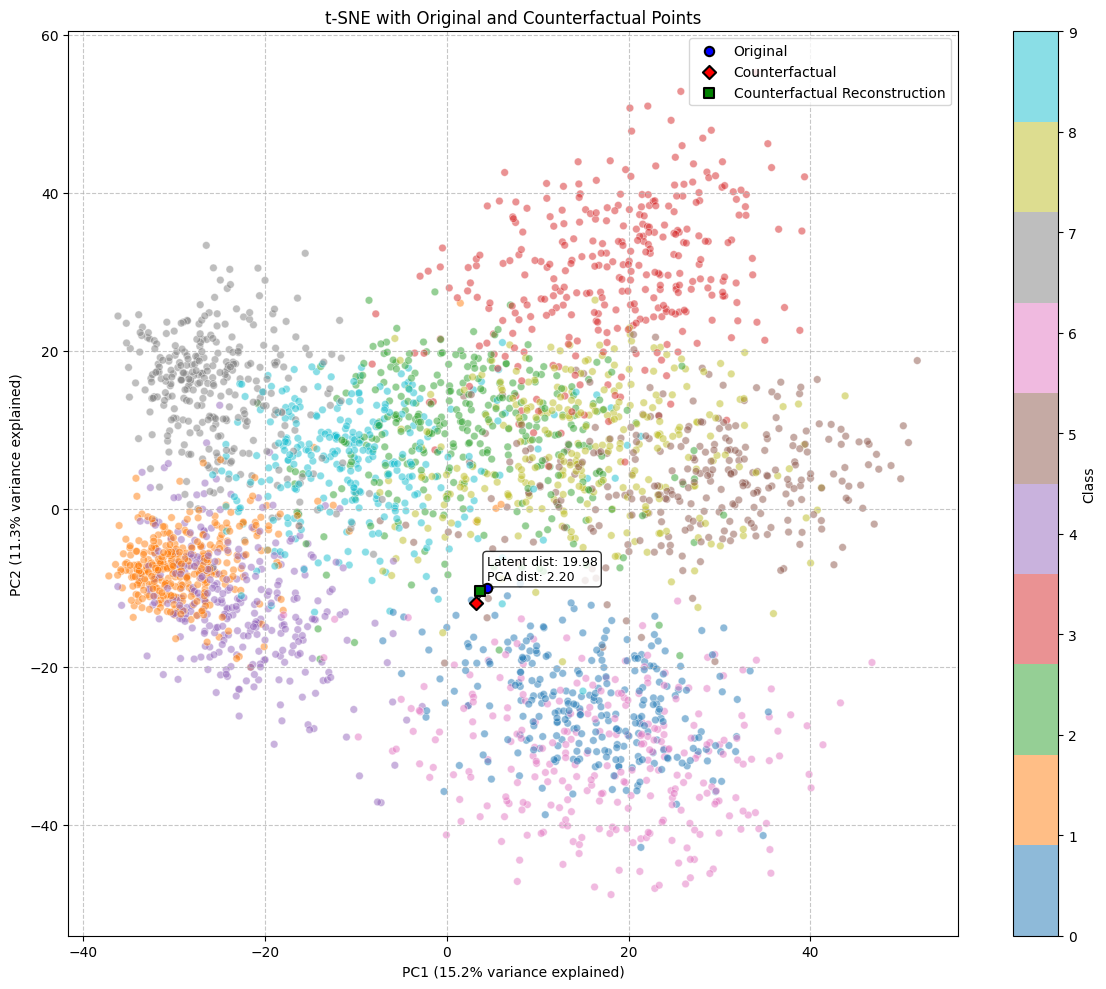

In [131]:
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import visualize_latent_space_with_pca

# Use the function with your data
tsne, fig, ax, coords = visualize_latent_space_with_pca(
    dataloader=testloader,
    model=bll_vi,
    original_latent=results['original_latent'],
    counterfactual_latent=results['counterfactual_latent'],
    reconstruction_latent=bll_vi.extract_features(results['counterfactual_image']),  # Optional, include if you have it
    batch_size=3000,  # Use a subset of the data for faster computation
    device=cfg.device,
    title="t-SNE with Original and Counterfactual Points"
)

### Test multiple

In [85]:
# Get 50 random images from the test set
import random
import torch

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Number of images to select
num_images = 50

# Get random indices from the test set
random_indices = random.sample(range(len(testset)), num_images)

# Get the images and their true labels
random_images = []
true_labels = []

for idx in random_indices:
    img, label = testset[idx]
    random_images.append(img.unsqueeze(0))  # Add batch dimension
    true_labels.append(label)

# Stack images into a single tensor
random_images = torch.cat(random_images, dim=0)

# Generate random target labels that are different from the true labels
target_labels = []
for true_label in true_labels:
    # Get all possible labels except the true one
    possible_labels = list(range(10))  # Assuming 10 classes (0-9) for MNIST
    possible_labels.remove(true_label)
    # Randomly select one of the remaining labels
    target_label = random.choice(possible_labels)
    target_labels.append(target_label)

print(f"Selected {num_images} random images with their true labels:")
print(f"True labels: {true_labels}")
print(f"Target labels: {target_labels}")



Selected 50 random images with their true labels:
True labels: [2, 1, 2, 4, 6, 6, 4, 9, 1, 1, 2, 8, 9, 0, 1, 2, 8, 8, 9, 6, 2, 9, 3, 2, 2, 3, 6, 2, 4, 4, 5, 3, 7, 3, 1, 1, 3, 1, 8, 8, 3, 9, 9, 5, 1, 3, 3, 0, 3, 7]
Target labels: [5, 6, 4, 1, 0, 3, 5, 1, 4, 2, 7, 4, 7, 6, 3, 6, 5, 3, 4, 1, 3, 8, 4, 3, 8, 7, 4, 9, 3, 6, 0, 4, 0, 6, 7, 5, 1, 4, 5, 3, 8, 6, 7, 2, 5, 2, 4, 9, 9, 4]


In [113]:
# Display the first random image
plt.figure(figsize=(3, 3))
plt.imshow(random_images[0].squeeze().cpu().numpy(), cmap='gray')
plt.title(f"True label: {true_labels[0]}, Target: {target_labels[0]}")
plt.axis('off')
plt.show()

NameError: name 'random_images' is not defined

<Figure size 300x300 with 0 Axes>

Run multiple clue to test

bayesian version first

In [100]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_class_counterfactuals

bayesian = True

if bayesian:
    model = bll_vi
else:
    model = backbone

results = evaluate_class_counterfactuals(
    random_images,
    model,
    decoder,
    vae,
    device=cfg.device,
    steps=200,
    lr=0.2,
    distance_weight=0.001,
    bayesian=bayesian,
    target_classes=target_labels
)


Aggregate Results over 50 images:
Average target class confidence: 0.358
Average latent distance: 50.782
Average log likelihood difference: 38.508
Average realism score difference: 0.018


Example 1 (Image Index: 12):
Target class confidence: 1.000
Latent distance: 43.803
Log likelihood difference: 20.179
Original class prediction: 9
Target class: 7

Example 2 (Image Index: 37):
Target class confidence: 0.991
Latent distance: 41.349
Log likelihood difference: 65.729
Original class prediction: 1
Target class: 4

Example 3 (Image Index: 8):
Target class confidence: 0.983
Latent distance: 41.281
Log likelihood difference: 69.616
Original class prediction: 1
Target class: 4

Example 4 (Image Index: 18):
Target class confidence: 0.898
Latent distance: 46.880
Log likelihood difference: 23.254
Original class prediction: 9
Target class: 4

Example 5 (Image Index: 11):
Target class confidence: 0.893
Latent distance: 42.215
Log likelihood difference: 28.220
Original class prediction: 8
Target c

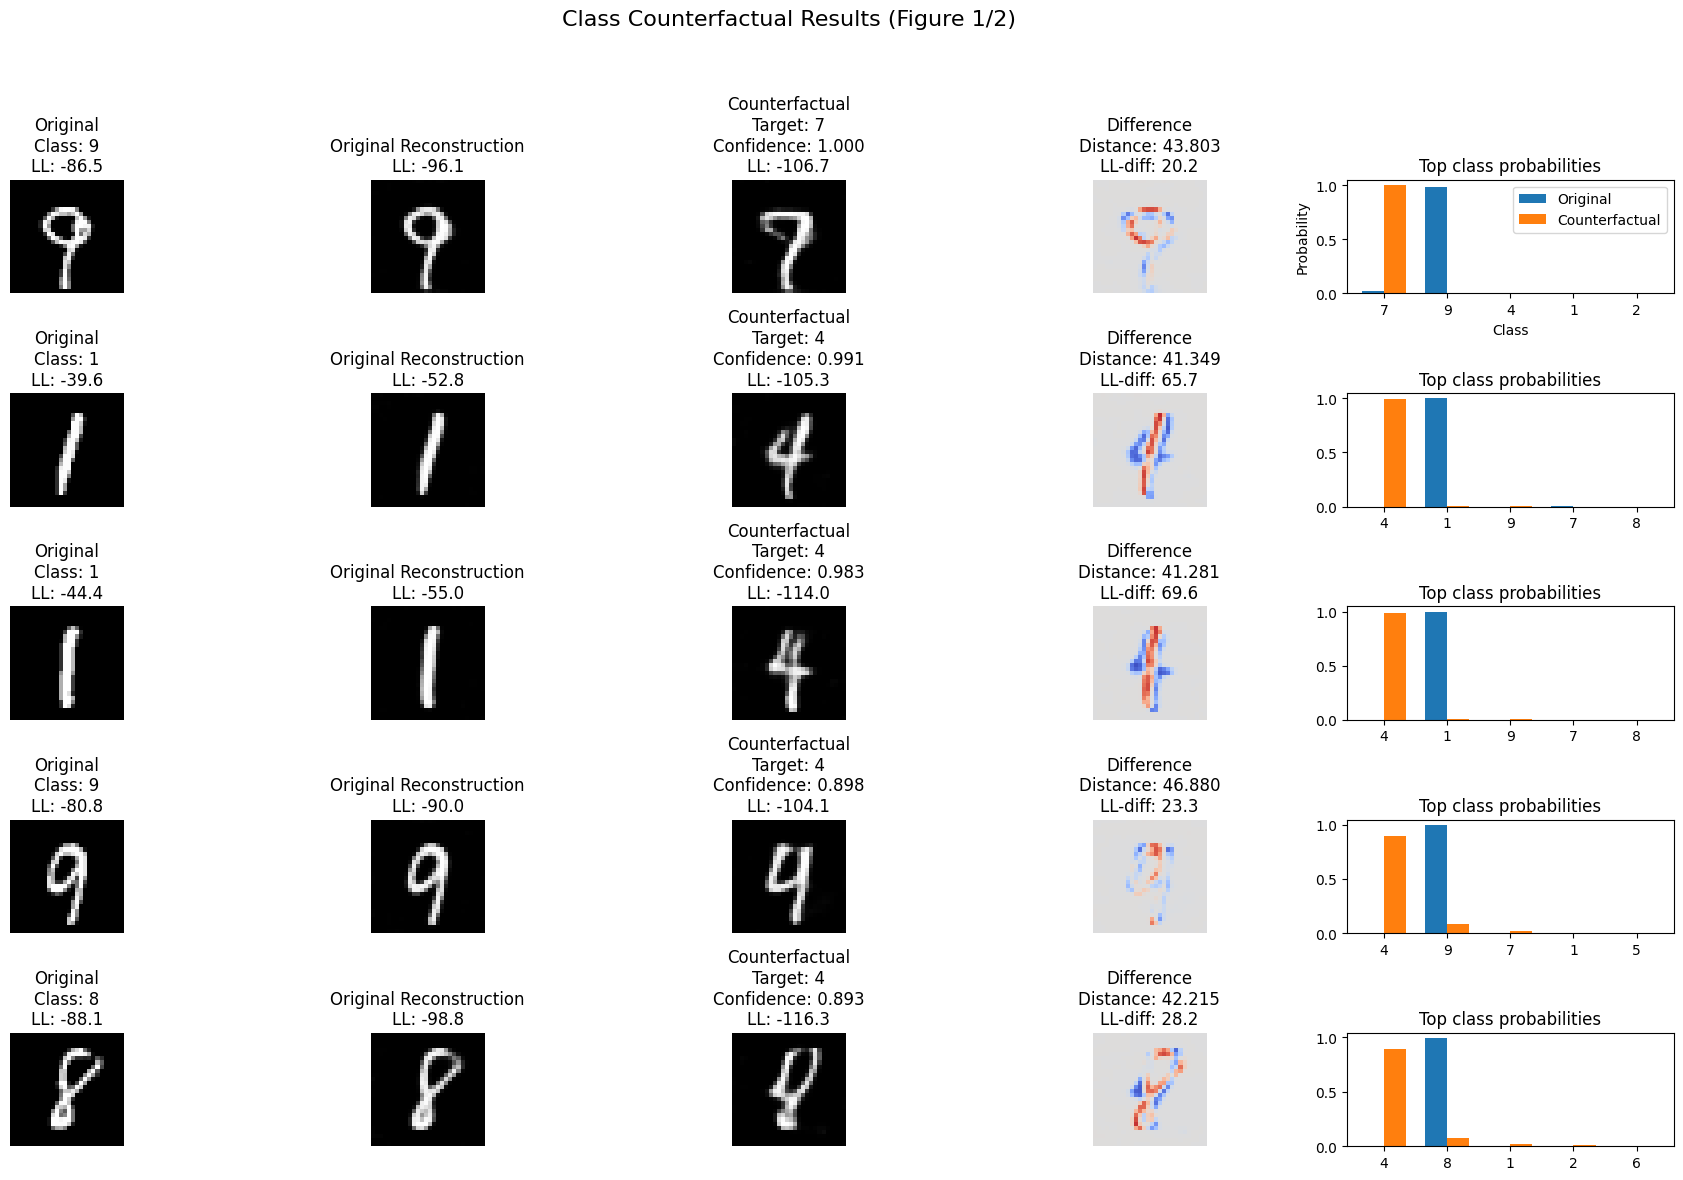

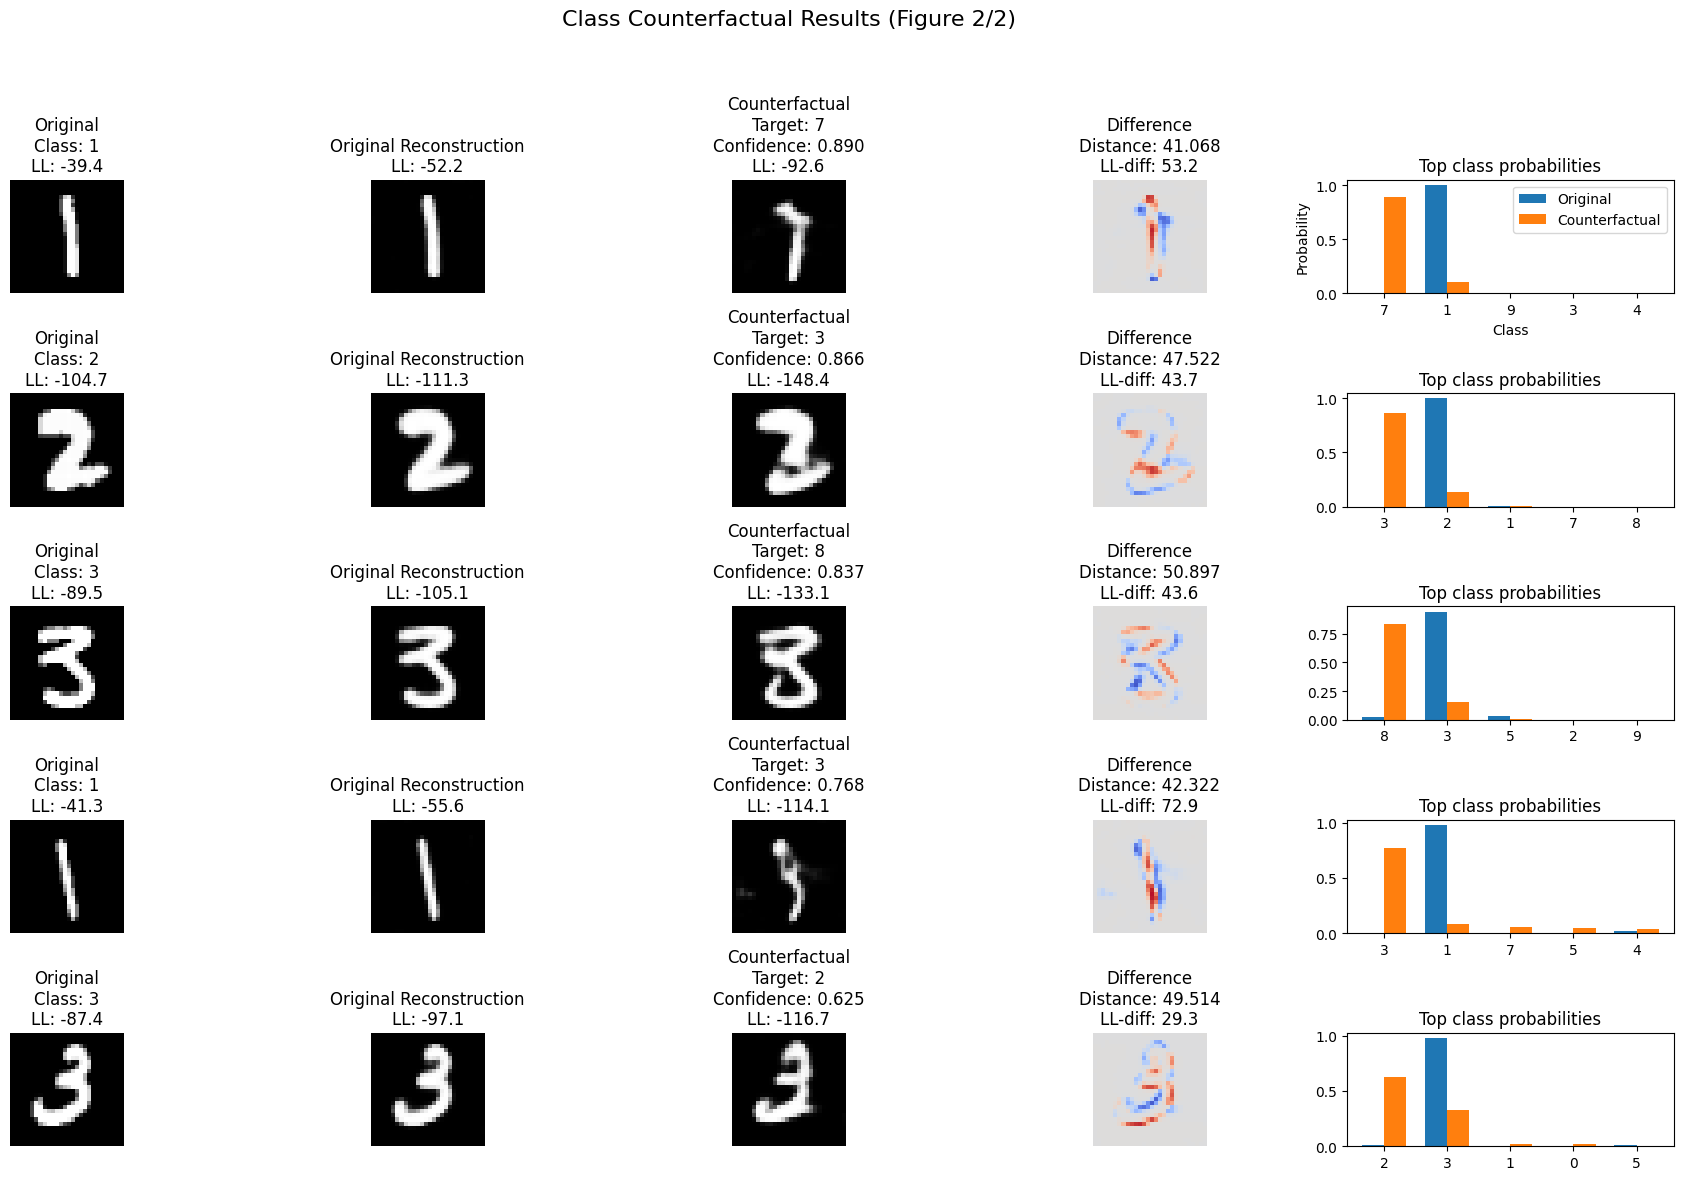

In [101]:
from clue.evaluate_CLUE import visualize_class_counterfactual_results
visualize_class_counterfactual_results(results, n=10)

In [91]:
from clue.evaluate_CLUE import save_class_counterfactual_results_to_csv
save_class_counterfactual_results_to_csv(results, output_dir=results_dir, suffix='test_bayesian_random_images_lower_lr')

Individual results saved to: ../results/new_regene_models/test_bayesian_random_images_lower_lr_2025-03-10_19-14-54/individual_results.csv
Aggregate results saved to: ../results/new_regene_models/test_bayesian_random_images_lower_lr_2025-03-10_19-14-54/aggregate_results.csv


('../results/new_regene_models/test_bayesian_random_images_lower_lr_2025-03-10_19-14-54/individual_results.csv',
 '../results/new_regene_models/test_bayesian_random_images_lower_lr_2025-03-10_19-14-54/aggregate_results.csv')

In [102]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import save_class_counterfactual_images
save_class_counterfactual_images(results, output_dir=results_dir)

Saved 50 counterfactual visualizations to ../results/new_regene_models_20250310_202348


['../results/new_regene_models_20250310_202348/counterfactual_001_img0000_target5.png',
 '../results/new_regene_models_20250310_202348/counterfactual_002_img0001_target6.png',
 '../results/new_regene_models_20250310_202348/counterfactual_003_img0002_target4.png',
 '../results/new_regene_models_20250310_202348/counterfactual_004_img0003_target1.png',
 '../results/new_regene_models_20250310_202348/counterfactual_005_img0004_target0.png',
 '../results/new_regene_models_20250310_202348/counterfactual_006_img0005_target3.png',
 '../results/new_regene_models_20250310_202348/counterfactual_007_img0006_target5.png',
 '../results/new_regene_models_20250310_202348/counterfactual_008_img0007_target1.png',
 '../results/new_regene_models_20250310_202348/counterfactual_009_img0008_target4.png',
 '../results/new_regene_models_20250310_202348/counterfactual_010_img0009_target2.png',
 '../results/new_regene_models_20250310_202348/counterfactual_011_img0010_target7.png',
 '../results/new_regene_models_2